<a href="https://colab.research.google.com/github/alfredoh90/Capstone3/blob/main/Classification_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Having successfully trained the model and achieved satisfactory results for our case study, our next objective is to gain insights into the decision-making process of the neural network, particularly in determining whether an image displays a person wearing safety gear. To achieve this, we will employ Gradient-weighted Class Activation Mapping (Grad-CAM).

The initial step in our analysis involves importing the necessary packages and loading our trained model, <code>safety_gear_detect_V4.keras</code>.

In [ ]:
#import required packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
#loading the model
model = tf.keras.models.load_model("/content/drive/MyDrive/Capstone3/safety_gear_detect_V4.keras")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 400, 400, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 400, 400, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 400, 400, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 50, 50, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 50, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 358,688,198 (1.34 GB)

 Trainable params: 179,343,106 (684.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 179,343,108 (684.14 MB)

Now that we have successfully loaded the model and reviewed its structure, the next step is to validate its performance. We will do this by testing the model with one of the test images used during the training process. This will allow us to confirm the accuracy and consistency of the results generated by the model.

In [ ]:
# Load and preprocess an example image for classification
img_path_pos = '/content/drive/MyDrive/Capstone3/data/test/pos/helmet_jacket_07365.jpg'
img = image.load_img(img_path_pos)

# Manually preprocessing image as we did when training
preprocessed_image = img.resize((400, 400))
preprocessed_image = np.array(preprocessed_image) / 255.0
img_tensor = tf.convert_to_tensor(np.expand_dims(preprocessed_image, axis=0))

In [ ]:
# Get model predictions and label
predictions = model(img_tensor)
predicted_class = np.argmax(predictions[0])
labels = ['pos', 'neg']
print(f"Predicted class: {labels[predicted_class]}")

Predicted class: pos


The results are consistent with the observations made during the modeling and testing phases. Next, we will proceed to create the model for gradient calculation. To achieve this, we will identify the last convolutional layer and utilize it along with the model’s inputs and outputs to construct the <code>grad_model</code>. This specialized model will enable us to compute the gradients effectively.

In [ ]:
# Get the last convolutional layer in the model
last_conv_layer = model.get_layer('conv2d_9')

In [ ]:
# Create a model that maps the input image to the activations of the last conv layer
grad_model = models.Model([model.inputs], [last_conv_layer.output, model.layers[-1].output])

Lets try it with the test image we used for analysis previously:

In [ ]:
# Get gradient of the winner class w.r.t. the input tensor
with tf.GradientTape() as gtape:
    gtape.watch(img_tensor) #reference the input tensor as the one to watch

    conv_output, predictions = grad_model(img_tensor, training = True) #generate the predictions

    loss = predictions[:, np.argmax(predictions[0])]

    # Get the gradient of the loss with respect to the input tensor
    grads = gtape.gradient(predictions[0], img_tensor)


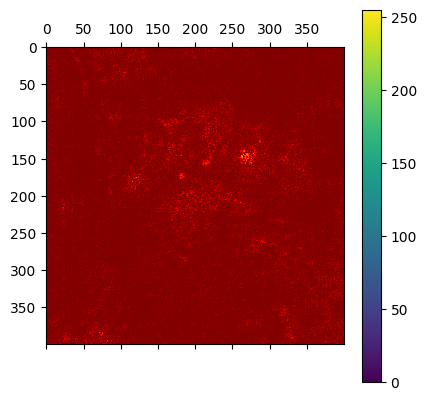

In [ ]:
# Apply ReLU to the heatmap
heatmap = tf.maximum(grads[0], 0)
heatmap /= tf.reduce_max(heatmap)

# Convert the heatmap to numpy array
heatmap = heatmap.numpy()

# Superimpose the heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Plot the heatmap
plt.matshow(heatmap)
plt.colorbar()
plt.show()

The results above illustrate that the heatmap highlights the pixels with the greatest influence on the model's prediction. In this case, we observe several regions where pixel concentration is notably high. However, it would be more convenient to review these findings if we could view the original image alongside the heatmap. To facilitate this, we will create functions to display both the original image and the heatmap side by side.

In [ ]:
def create_heatmap(g_model, img_tensor):
  # Get gradient of the winner class w.r.t. the input tensor
  with tf.GradientTape() as gtape:
    gtape.watch(img_tensor)#reference the input tensor as the one to watch
    conv_output, predictions = grad_model(img_tensor, training = True) #predict and get output of last conv layer
    loss = predictions[:, np.argmax(predictions[0])] #calculate loss

    # Get the gradient of the loss with respect to the input tensor
    grads = gtape.gradient(predictions[0], img_tensor)


  # Apply ReLU to the heatmap
  heatmap = tf.maximum(grads[0], 0)
  heatmap /= tf.reduce_max(heatmap)

  # Convert the heatmap to numpy array
  heatmap = heatmap.numpy()

  # This process makes the heatmap easier to understand by turning the numbers into colors
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  return heatmap

In [ ]:
def plot_images(img, heatmap):
  # Initialise the subplot function using number of rows and columns
  figure, axis = plt.subplots(1, 2, figsize=(10, 10))
  #first plot the original image
  axis[0].imshow(img)
  axis[0].set_title('Original Image')
  axis[0].axis('off')

  #then plot the heatmap
  heatmap_img = axis[1].imshow(heatmap)
  axis[1].set_title('Heatmap')
  axis[1].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def analyze_image(g_model, img_name):
  # Load and preprocess an example image for classification
  img_path_pos = '/content/drive/MyDrive/Capstone3/data/test/pos/' + img_name
  img = image.load_img(img_path_pos)

  # Manually preprocessing image as we did when training
  preprocessed_image = img.resize((400, 400))
  preprocessed_image = np.array(preprocessed_image) / 255.0
  img_tensor = tf.convert_to_tensor(np.expand_dims(preprocessed_image, axis=0))

  # Get model predictions and label
  #predictions = g_model(img_tensor)
  conv_output, predicted_class = g_model(img_tensor)
  labels = ['pos', 'neg']
  print(f"Predicted class: {labels[np.argmax(predicted_class[0])]}")

  #calculate gradient
  heatmap = create_heatmap(g_model, img_tensor)

  #plot heatmap and image
  plot_images(img, heatmap)

We will now use this function to be able to calculate the gradients and compare to the input image:

Predicted class: pos


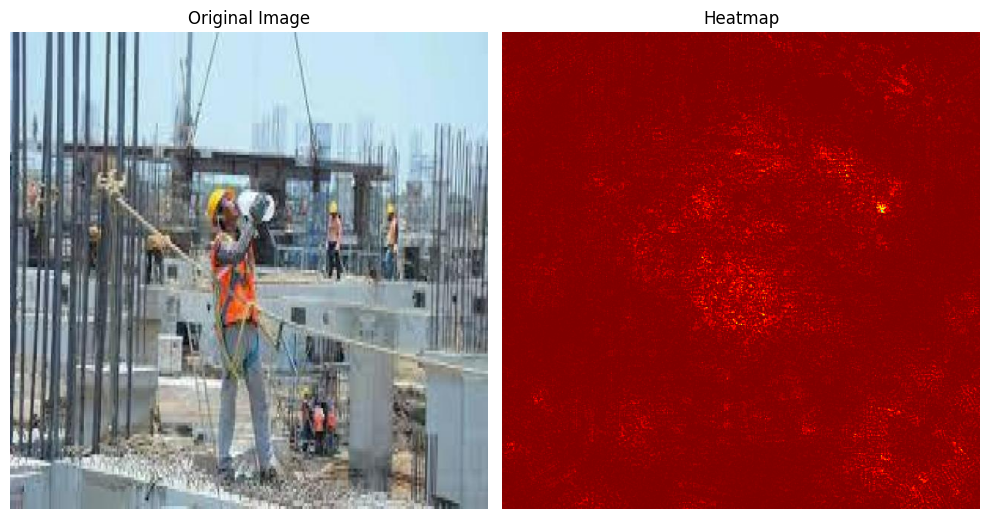

In [ ]:
analyze_image(grad_model, 'helmet_jacket_07365.jpg')

Predicted class: pos


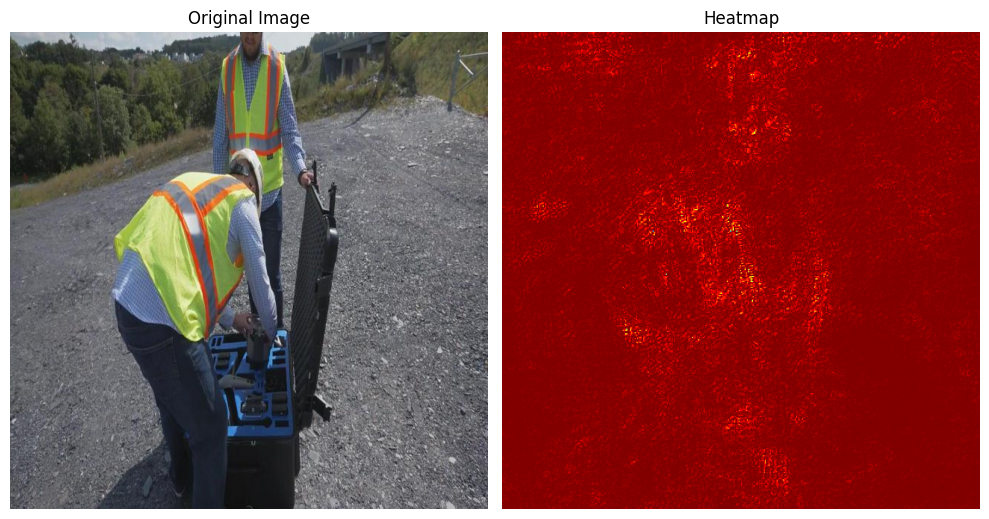

In [ ]:
analyze_image(grad_model, 'helmet_jacket_07353.jpg')

Predicted class: pos


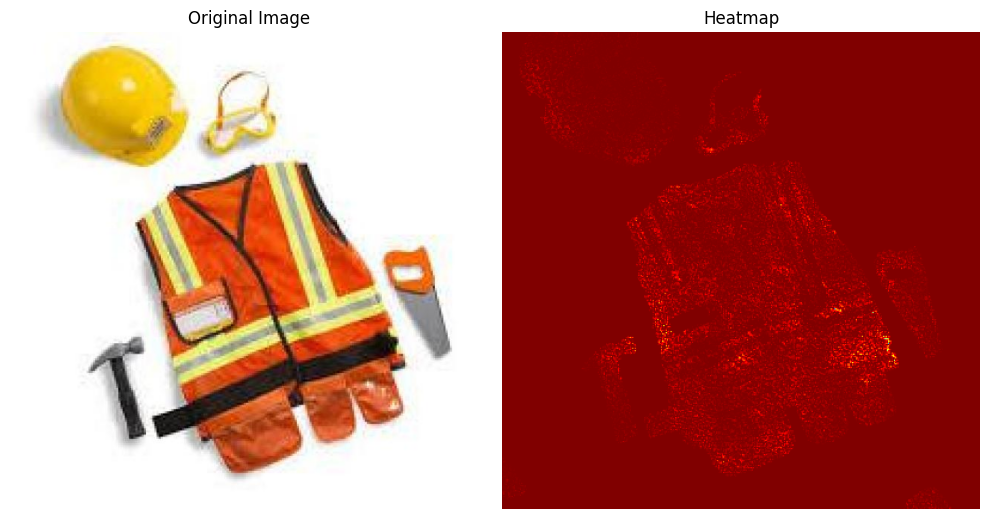

In [ ]:
analyze_image(grad_model, 'helmet_jacket_07360.jpg')

Predicted class: pos


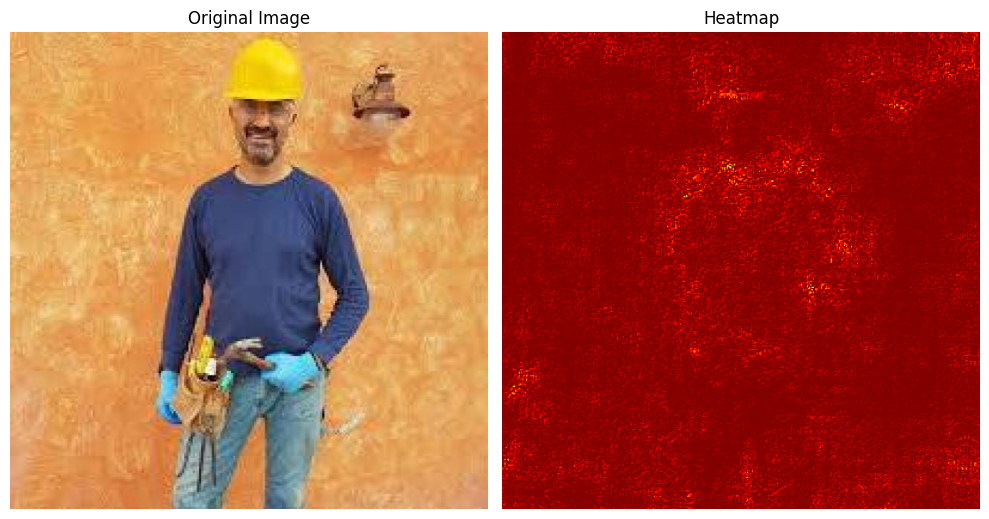

In [ ]:
analyze_image(grad_model, 'helmet_jacket_07380.jpg')

Predicted class: pos


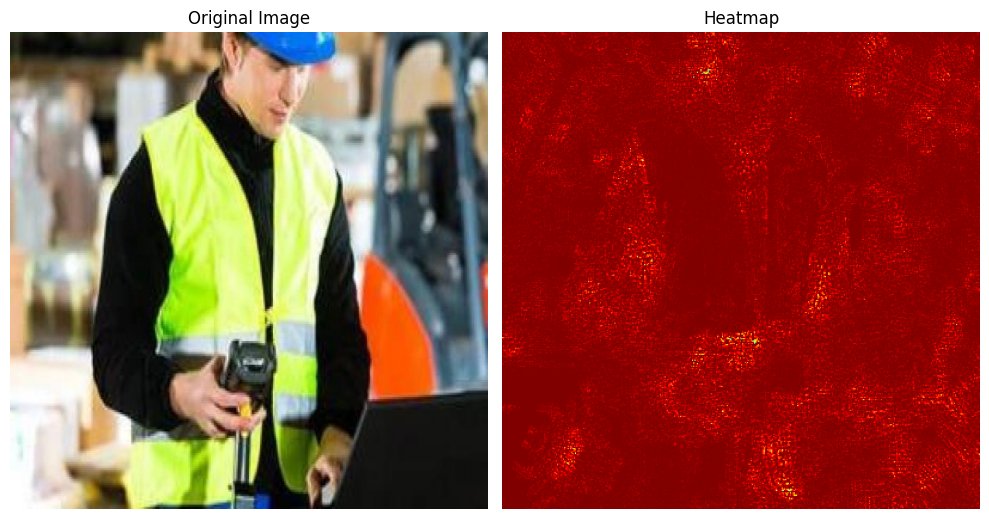

In [ ]:
analyze_image(grad_model, 'helmet_jacket_07451.jpg')

Predicted class: pos


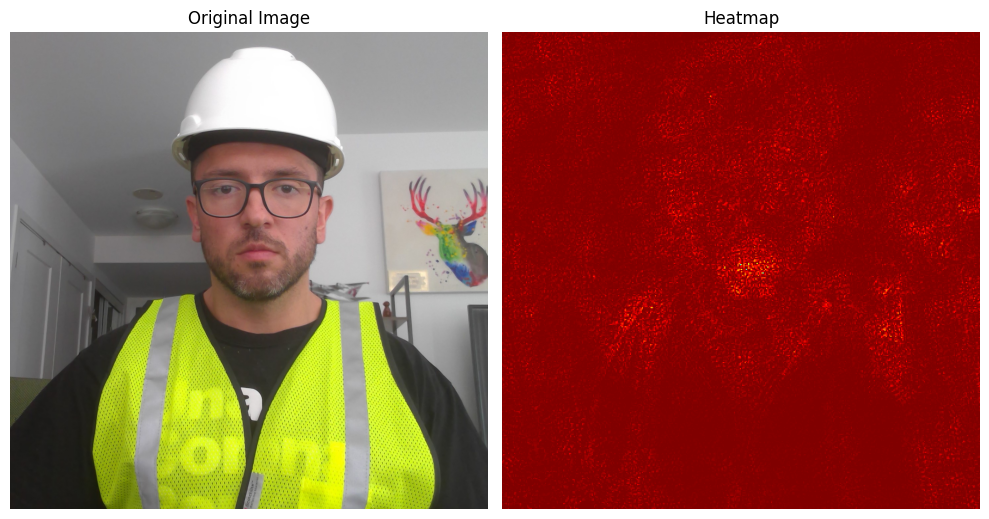

In [ ]:
analyze_image(grad_model, 'home_1.jpg')

Predicted class: pos


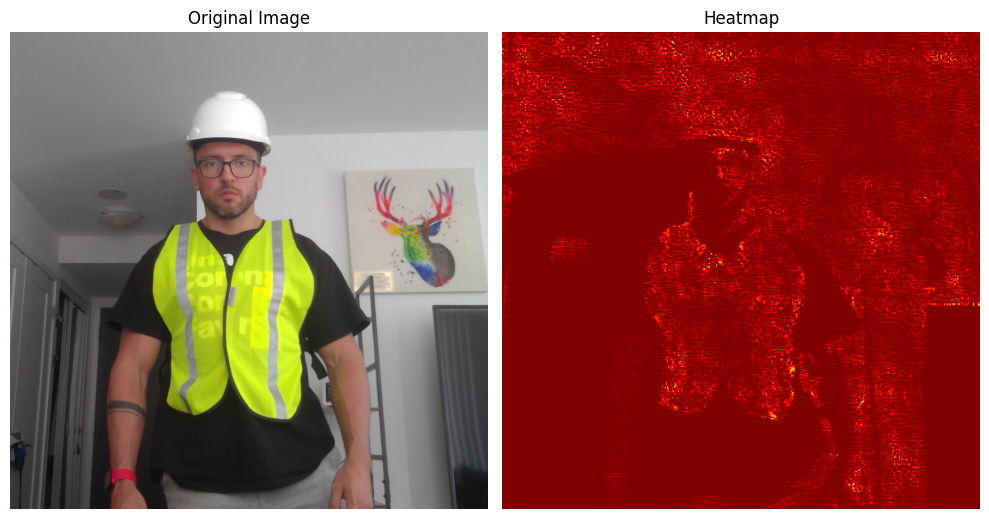

In [ ]:
analyze_image(grad_model, 'home_2.jpg')

Predicted class: pos


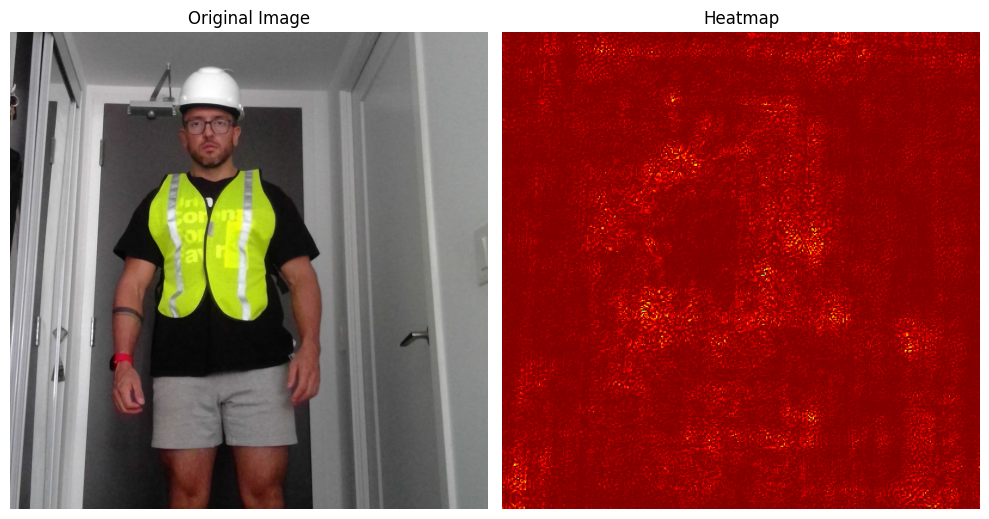

In [ ]:
analyze_image(grad_model, 'home_3.jpg')